In [10]:
# ! pip install torchaudio
# ! pip install torch
# ! pip install -U encodec
# ! pip install pydub
# ! pip install ffmpeg
# ! pip install ffprobe-python
# ! pip install transformers
# ! pip install wav2clip

In [ ]:
import logging
import pandas as pd
import numpy as np
import contextlib
import tempfile
import shutil
import torchaudio
import torch
import boto3
import wav2clip
import librosa

from numpy import dot
from numpy.linalg import norm
from encodec import EncodecModel
from encodec.utils import convert_audio
from pydub import AudioSegment
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model, AutoProcessor, Wav2Vec2BertModel

In [2]:
@contextlib.contextmanager
def make_temp_directory():
    """Context manager for creating temp directories."""
    temp_dir = tempfile.mkdtemp()
    try:
        yield temp_dir
    finally:
        shutil.rmtree(temp_dir)

In [3]:
def cosine_sim(ar1, ar2):
    return dot(ar1, ar2)/(norm(ar1)*norm(ar2))

## Sample dataset

In [4]:
aws_access_key_id = ""
aws_secret_access_key = ""
schema = "https"
host = "storage.yandexcloud.net"
bucket_name = ""

In [5]:
s3_client = boto3.client(
        "s3",
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        endpoint_url=f"{schema}://{host}",
    )

In [16]:
paginator = s3_client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix='encodec_emb')

In [17]:
genre_list = []
song_list = []

for page in pages:
    for obj in page['Contents']:
        if "audio.wav" in obj["Key"]:
            genre_list.append(obj["Key"].split("/")[1])
            song_list.append(obj["Key"].split("/")[2])

df_wav_songs = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": song_list,
    }
)

In [18]:
sample_dataset = pd.DataFrame()
for genre in df_wav_songs["genre"].unique():
    df_sample = df_wav_songs[df_wav_songs["genre"]==genre].sample(10)
    if sample_dataset.empty:
        sample_dataset = df_sample
    else:
        sample_dataset = pd.concat([sample_dataset, df_sample])

In [33]:
# sample_dataset.to_csv("sample_dataset.csv", index=False)
sample_dataset = pd.read_csv("sample_dataset.csv")

In [20]:
sample_dataset['genre'].unique()

array(['acoustic', 'alt-rock', 'ambient', 'black-metal', 'bluegrass',
       'blues', 'brazil', 'cantopop', 'children', 'club', 'country',
       'dancehall', 'death-metal', 'disco', 'dub', 'emo', 'forro', 'funk',
       'gospel', 'goth', 'hip-hop', 'indian', 'k-pop', 'latin', 'malay',
       'mandopop', 'mpb', 'new-age', 'salsa', 'spanish', 'turkish'],
      dtype=object)

In [10]:
genres = [
    "black-metal",
    "blues",
    "children",
    "death-metal",
    "hip-hop",
    "k-pop"
]

## Wav2Clip embeddings

In [44]:
wav2clip_model = wav2clip.get_model()

In [45]:
%%time

wav, sr = torchaudio.load("audio_30sec.wav")
wav = wav.numpy()
embedding = wav2clip.embed_audio(wav, wav2clip_model)

CPU times: user 1.69 s, sys: 445 ms, total: 2.13 s
Wall time: 2.28 s


In [46]:
embedding.shape

(2, 512)

In [9]:
genre_list = []
key_list = []
emb_list = []

for _, row in sample_dataset[sample_dataset["genre"].isin(genres)].iterrows():
    with make_temp_directory() as temp_dir:
        s3_client.download_file(
            Bucket=bucket_name,
            Key=f"encodec_emb/{row['genre']}/{row['song_name']}/audio.wav",
            Filename=f"{temp_dir}/audio.wav"
        )

        wav, sr = torchaudio.load(f"{temp_dir}/audio.wav")
        wav = wav.numpy()
        embedding = wav2clip.embed_audio(wav, wav2clip_model)
        with open(f"{temp_dir}/{row['song_name']}.npy", 'wb') as f:
            np.save(f, embedding)
        
        s3_client.upload_file(
            Bucket=bucket_name,
            Key=f"wav2clip_emb/{row['genre']}/{row['song_name']}/embedding.npy",
            Filename=f"{temp_dir}/{row['song_name']}.npy"
        )

        genre_list.append(row["genre"])
        key_list.append(row["song_name"])
        emb_list.append(embedding)        

In [10]:
wav2clip_emb = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": key_list,
        "emb": emb_list
    }
)

In [11]:
wav2clip_emb.to_csv("wav2clip_emb.csv", index=False)

## Wav2Vec2 embeddings

In [ ]:
model_name = "facebook/wav2vec2-large-xlsr-53"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2Model.from_pretrained(model_name)

In [77]:
%%time

wav, sr = librosa.load("audio_30sec.wav",  sr=16000)

i = feature_extractor(wav, return_tensors="pt", sampling_rate=16_000)
with torch.no_grad():
    o = model(i.input_values)
    embedding = o.extract_features

CPU times: user 16.1 s, sys: 7.37 ms, total: 16.1 s
Wall time: 16.1 s


In [78]:
embedding.shape

torch.Size([1, 1499, 512])

In [ ]:
genre_list = []
key_list = []
emb_list = []

for _, row in sample_dataset[sample_dataset["genre"].isin(genres)].iterrows():
    with make_temp_directory() as temp_dir:
        s3_client.download_file(
            Bucket=bucket_name,
            Key=f"encodec_emb/{row['genre']}/{row['song_name']}/audio.wav",
            Filename=f"{temp_dir}/audio.wav"
        )

        wav, sr = librosa.load(f"{temp_dir}/audio.wav",  sr=16000)

        i = feature_extractor(wav, return_tensors="pt", sampling_rate=16_000)
        with torch.no_grad():
            o = model(i.input_values)
            embedding = o.extract_features[0].numpy().mean(axis=0)

        with open(f"{temp_dir}/{row['song_name']}.npy", 'wb') as f:
            np.save(f, embedding)
        
        s3_client.upload_file(
            Bucket=bucket_name,
            Key=f"wav2vec2_emb/{row['genre']}/{row['song_name']}/embedding.npy",
            Filename=f"{temp_dir}/{row['song_name']}.npy"
        )

        genre_list.append(row["genre"])
        key_list.append(row["song_name"])
        emb_list.append(embedding)        

In [ ]:
wav2vec2_emb = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": key_list,
        "emb": emb_list
    }
)

In [ ]:
wav2vec2_emb.head()

,genre,song_name,emb
0,black-metal,Yekteniya_I:_OchishcheniyeBatushka,"[0.07502692, -0.7963427, -1.3260783, 0.7372482..."
1,black-metal,Consumed_by_a_Dark_ParanoiaXasthur,"[-0.020627644, -0.8566565, -1.072061, 0.925380..."
2,black-metal,In_Black_Endless_VoidOld_Man's_Child,"[-0.09175618, -0.70288736, -1.2903589, 0.74422..."
3,black-metal,One_for_the_ButcherWinds_of_Plague,"[-0.049299072, -0.7036041, -1.2930634, 0.77107..."
4,black-metal,Hell_Chose_MeCarnifex,"[-0.048799817, -0.72137815, -1.26047, 0.518918..."


In [ ]:
wav2vec2_emb.to_csv("wav2vec2_emb.csv", index=False)

## Wav2Vec2-BERT embeddings

In [6]:
model_name = "hf-audio/wav2vec2-bert-CV16-en"
processor = AutoProcessor.from_pretrained(model_name)
model = Wav2Vec2BertModel.from_pretrained(model_name)

In [7]:
%%time

wav, sr = librosa.load("audio_30sec.wav",  sr=16000)

inputs = processor(wav, sampling_rate=sr, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
embedding = outputs.extract_features.numpy()

CPU times: user 29.2 s, sys: 17.6 s, total: 46.8 s
Wall time: 55.4 s


In [8]:
embedding.shape

(1, 1499, 160)

In [ ]:
genre_list = []
key_list = []
emb_list = []

for _, row in sample_dataset[sample_dataset["genre"].isin(genres)].iterrows():
    with make_temp_directory() as temp_dir:
        s3_client.download_file(
            Bucket=bucket_name,
            Key=f"encodec_emb/{row['genre']}/{row['song_name']}/audio.wav",
            Filename=f"{temp_dir}/audio.wav"
        )

        wav, sr = librosa.load(f"{temp_dir}/audio.wav",  sr=16000)

        inputs = processor(wav, sampling_rate=sr, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)

        embedding = outputs.extract_features.numpy()

        with open(f"{temp_dir}/{row['song_name']}.npy", 'wb') as f:
            np.save(f, embedding)
        
        s3_client.upload_file(
            Bucket=bucket_name,
            Key=f"wav2vec2_bert_emb/{row['genre']}/{row['song_name']}/embedding.npy",
            Filename=f"{temp_dir}/{row['song_name']}.npy"
        )

        genre_list.append(row["genre"])
        key_list.append(row["song_name"])
        emb_list.append(embedding)        

In [ ]:
wav2vec2_bert_emb = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": key_list,
        "emb": emb_list
    }
)

In [ ]:
wav2vec2_bert_emb.head()

,genre,song_name,emb
0,black-metal,Yekteniya_I:_OchishcheniyeBatushka,"[[0.45136946, -0.49411917, -0.5606431, 0.25914..."
1,black-metal,Consumed_by_a_Dark_ParanoiaXasthur,"[[0.45136946, -0.49411917, -0.5606431, 0.25914..."
2,black-metal,In_Black_Endless_VoidOld_Man's_Child,"[[0.45136946, -0.49411917, -0.5606431, 0.25914..."
3,black-metal,One_for_the_ButcherWinds_of_Plague,"[[0.45136946, -0.49411917, -0.5606431, 0.25914..."
4,black-metal,Hell_Chose_MeCarnifex,"[[0.45136946, -0.49411917, -0.5606431, 0.25914..."


In [ ]:
wav2vec2_bert_emb.head().to_csv("wav2vec2_bert_emb.csv", index=False)

## EnCodec Embeddings

In [ ]:
model = EncodecModel.encodec_model_24khz()

In [55]:
model.set_target_bandwidth(6.0)

In [56]:
%%time

wav, sr = torchaudio.load("audio_30sec.wav")
wav = convert_audio(wav, sr, model.sample_rate, model.channels)
wav = wav.unsqueeze(0)

with torch.no_grad():
    encoded_frames = model.encode(wav)
codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)

embedding = model.quantizer.decode(codes.transpose(0, 1)).squeeze()

CPU times: user 3.56 s, sys: 176 ms, total: 3.74 s
Wall time: 7.87 s


In [57]:
embedding.shape

torch.Size([128, 2250])

In [ ]:
genre_list = []
key_list = []
emb_list = []

for _, row in sample_dataset[sample_dataset["genre"].isin(genres)].iterrows():
    with make_temp_directory() as temp_dir:
        s3_client.download_file(
            Bucket=bucket_name,
            Key=f"encodec_emb/{row['genre']}/{row['song_name']}/audio.wav",
            Filename=f"{temp_dir}/audio.wav"
        )

        wav, sr = torchaudio.load(f"{temp_dir}/audio.wav")
        wav = convert_audio(wav, sr, model.sample_rate, model.channels)
        wav = wav.unsqueeze(0)

        with torch.no_grad():
            encoded_frames = model.encode(wav)
        codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1)

        embedding = model.quantizer.decode(codes.transpose(0, 1)).squeeze()
        
        torch.save(embedding, f"{temp_dir}/embedding.pt")

        s3_client.upload_file(
            Bucket=bucket_name,
            Key=f"encodec_emb/{row['genre']}/{row['song_name']}/embedding.pt",
            Filename=f"{temp_dir}/embedding.pt"
        )

        genre_list.append(row["genre"])
        key_list.append(row["song_name"])
        emb_list.append(embedding)        

In [ ]:
encodec_emb = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": key_list,
        "emb": emb_list
    }
)

In [ ]:
encodec_emb.head()

,genre,song_name,emb
0,black-metal,Yekteniya_I:_OchishcheniyeBatushka,"[[tensor(3.7474), tensor(5.2190), tensor(4.473..."
1,black-metal,Consumed_by_a_Dark_ParanoiaXasthur,"[[tensor(7.0689), tensor(5.3568), tensor(6.058..."
2,black-metal,In_Black_Endless_VoidOld_Man's_Child,"[[tensor(3.8695), tensor(4.9918), tensor(3.248..."
3,black-metal,One_for_the_ButcherWinds_of_Plague,"[[tensor(8.1341), tensor(4.7770), tensor(4.055..."
4,black-metal,Hell_Chose_MeCarnifex,"[[tensor(7.1851), tensor(8.1335), tensor(4.265..."


In [ ]:
encodec_emb.to_csv("encodec_emb.csv", index=False)

## Let's display and compare

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

### Quick data load 

In [11]:
sample_dataset = sample_dataset[sample_dataset["genre"].isin(genres)]

In [12]:
tensor_list = []
song_list = []
genre_list = []
for _, row in sample_dataset.iterrows():
    with make_temp_directory() as temp_dir:
        s3_client.download_file(
            Bucket=bucket_name,
            Key=f"encodec_emb/{row['genre']}/{row['song_name']}/tensor.pt",
            Filename=f"{temp_dir}/tensor.pt"
        )
        tensor = torch.load(f"{temp_dir}/tensor.pt").mean(axis=1)
        tensor_list.append(tensor.numpy())
        song_list.append(row["song_name"])
        genre_list.append(row["genre"])

encodec_emb = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": song_list,
        "emb": tensor_list
    }
)

In [13]:
emb_list = []
song_list = []
genre_list = []
for _, row in sample_dataset.iterrows():
    with make_temp_directory() as temp_dir:
        s3_client.download_file(
            Bucket=bucket_name,
            Key=f"wav2clip_emb/{row['genre']}/{row['song_name']}/embedding.npy",
            Filename=f"{temp_dir}/embedding.npy"
        )
        embedding = np.load(f"{temp_dir}/embedding.npy").mean(axis=0)
        emb_list.append(embedding)
        song_list.append(row["song_name"])
        genre_list.append(row["genre"])

wav2clip_emb = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": song_list,
        "emb": emb_list
    }
)

In [14]:
emb_list = []
song_list = []
genre_list = []
for _, row in sample_dataset.iterrows():
    with make_temp_directory() as temp_dir:
        s3_client.download_file(
            Bucket=bucket_name,
            Key=f"wav2vec2_emb/{row['genre']}/{row['song_name']}/embedding.npy",
            Filename=f"{temp_dir}/embedding.npy"
        )
        embedding = np.load(f"{temp_dir}/embedding.npy")
        emb_list.append(embedding)
        song_list.append(row["song_name"])
        genre_list.append(row["genre"])

wav2vec2_emb = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": song_list,
        "emb": emb_list
    }
)

In [15]:
emb_list = []
song_list = []
genre_list = []
for _, row in sample_dataset.iterrows():
    with make_temp_directory() as temp_dir:
        s3_client.download_file(
            Bucket=bucket_name,
            Key=f"wav2vec2_bert_emb/{row['genre']}/{row['song_name']}/embedding.npy",
            Filename=f"{temp_dir}/embedding.npy"
        )
        embedding = np.load(f"{temp_dir}/embedding.npy")[0].mean(axis=0)
        emb_list.append(embedding)
        song_list.append(row["song_name"])
        genre_list.append(row["genre"])

wav2vec2_bert_emb = pd.DataFrame(
    {
        "genre": genre_list,
        "song_name": song_list,
        "emb": emb_list
    }
)

### Plotting

In [58]:
encodec_emb["count_genre"] = encodec_emb.groupby("genre").cumcount()+1
wav2clip_emb["count_genre"] = wav2clip_emb.groupby("genre").cumcount()+1
wav2vec2_emb["count_genre"] = wav2vec2_emb.groupby("genre").cumcount()+1
wav2vec2_bert_emb["count_genre"] = wav2vec2_bert_emb.groupby("genre").cumcount()+1

In [60]:
def plot_heatmap(df, model_name):
    sim_dict = {}
    for _, row1 in df.iterrows():
        sim_list = []
        for _, row2 in df.iterrows():
            if row1["song_name"] != row2["song_name"]:
                sim_list.append(cosine_sim(row1["emb"], row2["emb"]))
            else:
                sim_list.append(1)
        sim_dict[f"{row1['genre']}_{row1['count_genre']}"] = sim_list
    sim_df = pd.DataFrame(sim_dict, index=list(sim_dict.keys()))
    sns.heatmap(sim_df)
    plt.title(f"{model_name} cosine similarity")
    plt.show()

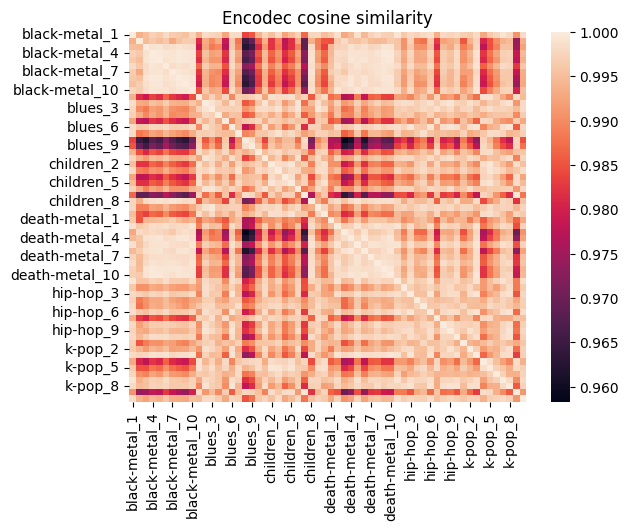

In [175]:
plot_heatmap(encodec_emb, "Encodec")

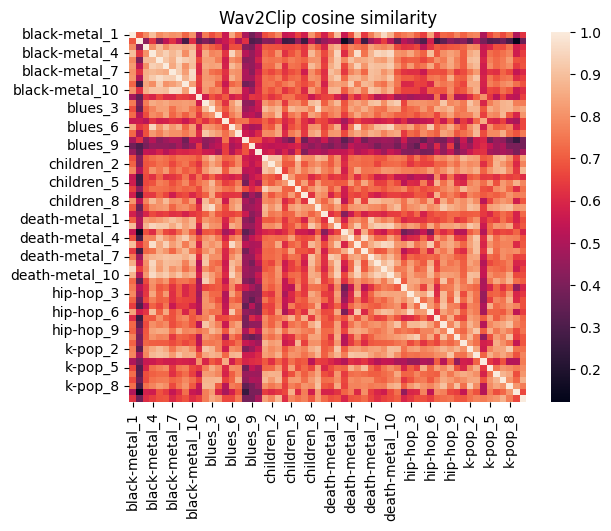

In [176]:
plot_heatmap(wav2clip_emb, "Wav2Clip")

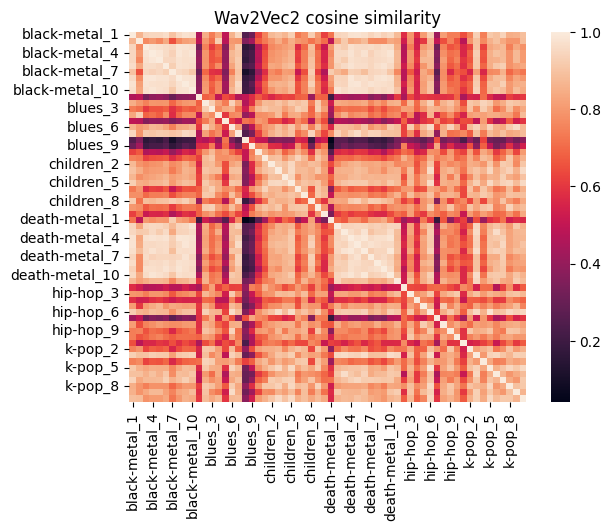

In [177]:
plot_heatmap(wav2vec2_emb, "Wav2Vec2")

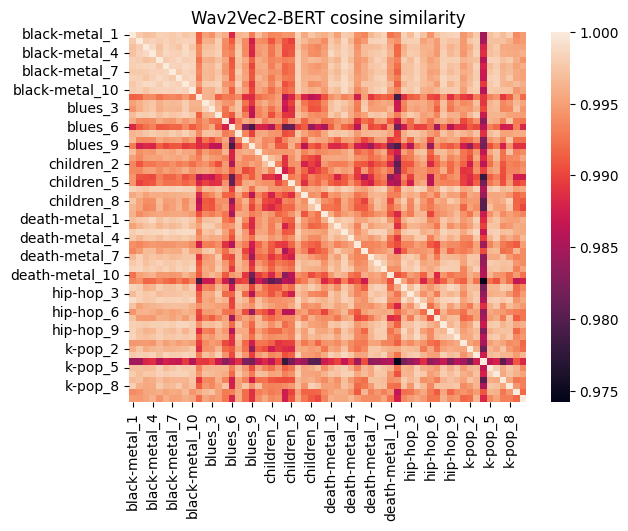

In [178]:
plot_heatmap(wav2vec2_bert_emb, "Wav2Vec2-BERT")

In [27]:
def plot_scatter(df, model_name):
    tsne = TSNE(n_components=2)
    arr = np.array(df['emb'].apply(list).tolist())
    tsne_arr = tsne.fit_transform(arr)
    df["x1"] = tsne_arr[:, 0]
    df["x2"] = tsne_arr[:, 1]

    sns.scatterplot(
        df, x="x1", y="x2", hue="genre"
    )
    plt.grid(True)
    plt.title(f"{model_name} embeddings")
    plt.legend(bbox_to_anchor=(1, 0.5))

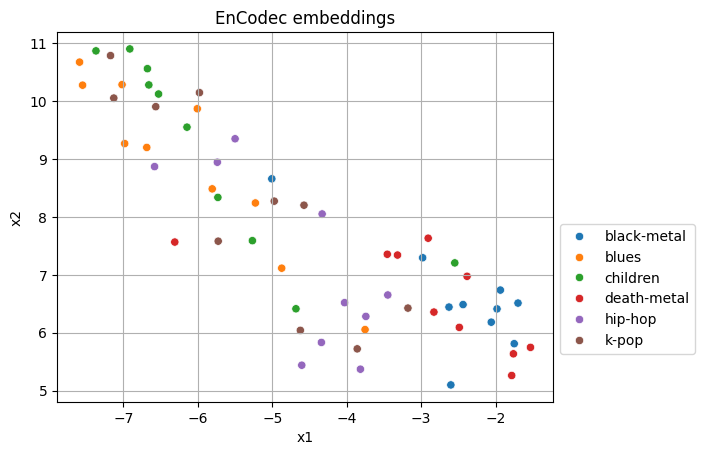

In [28]:
plot_scatter(encodec_emb, "EnCodec")

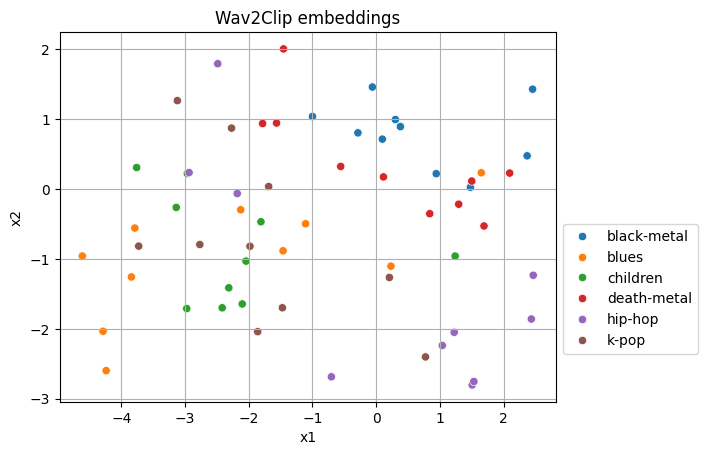

In [29]:
plot_scatter(wav2clip_emb, "Wav2Clip")

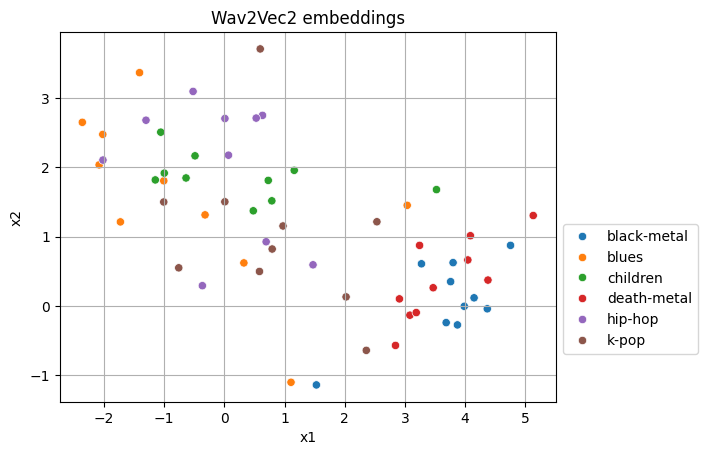

In [30]:
plot_scatter(wav2vec2_emb, "Wav2Vec2")

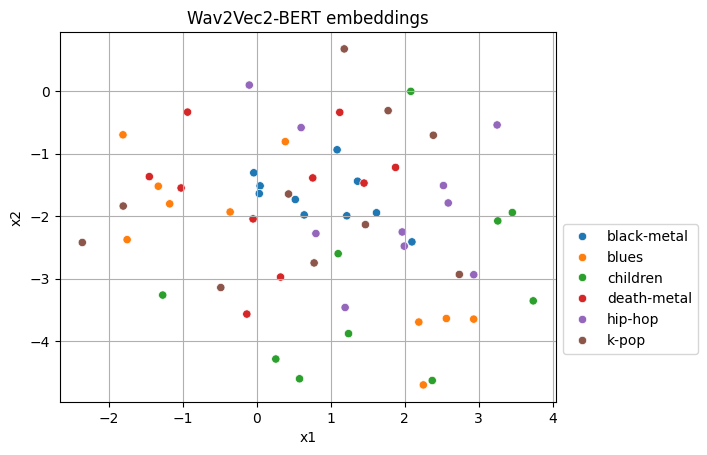

In [31]:
plot_scatter(wav2vec2_bert_emb, "Wav2Vec2-BERT")